# GradCame

In [11]:
import torch
import torch.nn as nn
import os
from torchcam.methods import SmoothGradCAMpp
from torchcam.utils import overlay_mask
import matplotlib
import matplotlib.pyplot as plt
import matplotlib.font_manager as fm
from torchvision import transforms
from PIL import Image
from model import MultiLabelImageClassifier
from utils import *
import yaml
import argparse
from torchvision.transforms.functional import to_pil_image
import warnings
import logging

# matplotlib findfont 경고 끄기
warnings.filterwarnings("ignore", category=UserWarning, module="matplotlib")
warnings.filterwarnings("ignore", message="findfont: Font family .* not found")
# matplotlib 내부 로깅 레벨을 WARNING 이상으로 올리기
logging.getLogger('matplotlib').setLevel(logging.WARNING)

# NotoSansCJK 폰트 경로 지정
font_path = '/usr/share/fonts/opentype/noto/NotoSansCJK-Regular.ttc'
font_prop = fm.FontProperties(fname=font_path)
plt.rcParams['font.family'] = font_prop.get_name()
plt.rcParams['axes.unicode_minus'] = False
# 마이너스 기호 깨짐 방지
matplotlib.rcParams['axes.unicode_minus'] = False

def visualize_gradcam_multi_task(config, image_path, target_classes):
    """
    target_classes: dict, 예) {'action': 3, 'emotion': 1, 'situation': 5}
    """
    print(f"target_classes: {target_classes}")
    print({k: type(v) for k,v in target_classes.items()})
    device = torch.device(config['device'] if torch.cuda.is_available() else 'cpu')
    
    # 모델 초기화 및 불러오기
    model_wrapper = MultiLabelImageClassifier(
        num_actions=len(config['label_names']['action']),
        num_emotions=len(config['label_names']['emotion']),
        num_situations=len(config['label_names']['situation']),
        backbone_name=config['model_name'],
        pretrained=False
    )
    model = model_wrapper.get_model()
    
    model_path = os.path.join(config['save_path'], config['model_name'] ,config['best_model_path'])
    assert os.path.exists(model_path), f"모델 경로 {model_path}가 존재하지 않습니다."
    
    model.load_state_dict(torch.load(model_path, map_location=device), strict=True)
    model.to(device)
    model.eval()
    
    # Grad-CAM extractor 생성 (backbone 마지막 conv layer)
    def get_target_layer(model_name, backbone):
        model_name = model_name.lower()
        if 'resnet' in model_name:
            return backbone.layer4
        elif 'efficientnet' in model_name:
            return backbone.blocks[-1]
        elif 'convnext' in model_name:
            if hasattr(backbone, 'downsample_layers'):
                return backbone.downsample_layers[-1]
            elif hasattr(backbone, 'stages'):
                return backbone.stages[-1]
            else:
                raise ValueError("ConvNeXt backbone 구조를 확인해주세요.")
        elif 'swin' in model_name:
            return backbone.layers[-1]
        else:
            raise ValueError(f"지원하지 않는 backbone 모델입니다: {model_name}")

    target_layer = get_target_layer(config['model_name'], model.shared_encoder)
    
    cam_extractor = SmoothGradCAMpp(model.shared_encoder, target_layer=target_layer)

    transform = transforms.Compose([
            transforms.Resize((224, 224)),
            transforms.RandomHorizontalFlip(),
            transforms.ToTensor(),
            transforms.Normalize(mean=[0.485, 0.456, 0.406],
                                 std=[0.229, 0.224, 0.225]),
        ])
    img = Image.open(image_path).convert('RGB')
    input_tensor = transform(img).unsqueeze(0).to(device)  # (1,3,224,224)
    input_tensor.requires_grad_()

    # Grad-CAM 계산은 gradient 필요하므로 enable_grad 컨텍스트 내에서 수행
    with torch.enable_grad():
        input_tensor.requires_grad_()
        action_logits, emotion_logits, situation_logits = model(input_tensor)
        
        print(f"action_logits.shape: {action_logits.shape}")
        print(f"emotion_logits.shape: {emotion_logits.shape}")
        print(f"situation_logits.shape: {situation_logits.shape}")
        
        def get_cam(logits, target_class):
            num_classes = logits.shape[1]
            if not (0 <= target_class < num_classes):
                raise ValueError(f"target_class {target_class} out of range [0, {num_classes-1}]")
            
            # batch_class_idx = torch.tensor([target_class], device=logits.device, dtype=torch.int64)
            class_idx = int(target_class)
            print(f"class_idx: {class_idx}, logits.shape: {logits.shape}, requires_grad: {logits.requires_grad}")
            
            cams = cam_extractor(class_idx, logits)
            return cams[0].cpu()

        cams = {
            'action': get_cam(action_logits, target_classes['action']),
            'emotion': get_cam(emotion_logits, target_classes['emotion']),
            'situation': get_cam(situation_logits, target_classes['situation']),
        }

    for i, task in enumerate(['action', 'emotion', 'situation']):
        plt.subplot(1, 3, i+1)

        # CAM 텐서 준비
        cam_tensor = cams[task]
        if cam_tensor.ndim == 2:
            cam_tensor = cam_tensor.unsqueeze(0)  # (1, H, W)

        cam_mask = to_pil_image(cam_tensor)  # torch.Tensor -> PIL.Image

        # 원본 이미지와 CAM 오버레이
        cam_img = overlay_mask(img, cam_mask, alpha=0.5)

        plt.imshow(cam_img)
        class_idx = target_classes[task]
        class_name = config['label_names'][task][class_idx]
        plt.title(f"{task.capitalize()} - {class_name}")
        plt.axis('off')

target_classes: {'action': 2, 'emotion': 1, 'situation': 11}
{'action': <class 'int'>, 'emotion': <class 'int'>, 'situation': <class 'int'>}
action_logits.shape: torch.Size([1, 13])
emotion_logits.shape: torch.Size([1, 6])
situation_logits.shape: torch.Size([1, 17])
class_idx: 2, logits.shape: torch.Size([1, 13]), requires_grad: True
class_idx: 1, logits.shape: torch.Size([1, 6]), requires_grad: True
class_idx: 11, logits.shape: torch.Size([1, 17]), requires_grad: True


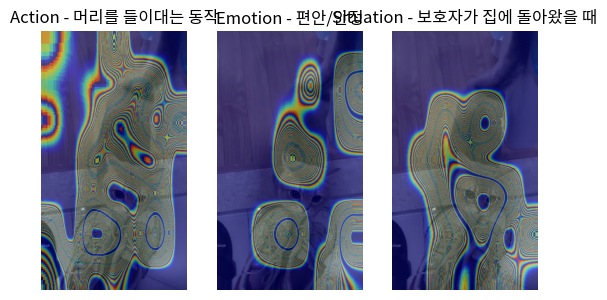

In [12]:
yaml_path = './configs/convnext.yaml'
with open(yaml_path) as f:
    config = yaml.safe_load(f)

label_maps = get_label_maps_from_config(config)
test_image_path = config['test_image_path']

# 시각화 하고 싶은 라벨명 지정
action_label = '머리를 들이대는 동작'
emotion_label = '편안/안정'
situation_label = '보호자가 집에 돌아왔을 때'

# 라벨명으로부터 인덱스 찾아서 target_classes 구성
target_classes = {
    'action': label_maps['action'][action_label],
    'emotion': label_maps['emotion'][emotion_label],
    'situation': label_maps['situation'][situation_label],
}

visualize_gradcam_multi_task(config, test_image_path, target_classes)

---

In [ ]:
import matplotlib.font_manager as fm

# 설치된 폰트 전체 경로 출력
for font in fm.findSystemFonts(fontpaths=None, fontext='ttf'):
    print(font)


In [ ]:
import matplotlib.pyplot as plt
import matplotlib.font_manager as fm

# NotoSansCJK 폰트 경로 지정
font_path = '/usr/share/fonts/opentype/noto/NotoSansCJK-Regular.ttc'
font_prop = fm.FontProperties(fname=font_path)

# 이 폰트를 전체에 기본 적용
plt.rcParams['font.family'] = font_prop.get_name()

In [13]:
import matplotlib.pyplot as plt
print("현재 설정된 폰트:", plt.rcParams['font.family'])

현재 설정된 폰트: ['Noto Sans CJK JP']
